<a href="https://colab.research.google.com/github/kridtapon/DPO-Williams-Momentum/blob/main/DPO_Williams_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Detrended Price Oscillator (DPO)
def calculate_dpo(df, period=20):
    """
    Calculate Detrended Price Oscillator (DPO).
    """
    # Calculate a moving average and subtract it from the close price to detrend
    moving_average = df['Close'].rolling(window=period).mean()
    dpo = df['Close'] - moving_average
    return dpo

# Function to calculate Williams %R
def calculate_williams_r(df, period=14):
    """
    Calculate Williams %R indicator.
    """
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()
    williams_r = -100 * ((high_rolling - df['Close']) / (high_rolling - low_rolling))
    return williams_r

# Define the stock symbol and time period
symbol = 'META'  # SPY is the symbol for the S&P 500 ETF
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Detrended Price Oscillator (DPO)
df['DPO'] = calculate_dpo(df, period=20)

# Calculate Williams %R
df['Williams_R'] = calculate_williams_r(df, period=14)

# Define Entry and Exit signals based on DPO and Williams %R
df['Entry'] = (df['DPO'] < 0) & (df['Williams_R'] < -80)
df['Exit'] = (df['Williams_R'] > -20) | (df['DPO'] > 0)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           235115.252976
Total Return [%]                       135.115253
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                      13188.562586
Max Drawdown [%]                        34.224305
Max Drawdown Duration                       282.0
Total Trades                                   45
Total Closed Trades                            44
Total Open Trades                               1
Open Trade PnL                       -2538.326113
Win Rate [%]                                 75.0
Best Trade [%]                          15.181776
Worst Trade [%]                        -17.505321
Avg Winning Trade [%]                    4.743214
Avg Losing Trade [%]                    -5.518397


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Detrended Price Oscillator (DPO)
def calculate_dpo(df, period):
    return df['Close'] - df['Close'].rolling(window=period).mean()

# Function to calculate Williams %R
def calculate_williams_r(df, period):
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()
    return -100 * ((high_rolling - df['Close']) / (high_rolling - low_rolling))

# Define stock and date range
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
dpo_periods = np.arange(10, 50, 5)  # DPO periods from 10 to 45
williams_periods = np.arange(10, 30, 5)  # Williams %R periods from 10 to 25

# Create parameter combinations
dpo_grid, williams_grid = np.meshgrid(dpo_periods, williams_periods, indexing='ij')

# Calculate indicators for all parameter sets
dpo_values = vbt.IndicatorFactory.from_pandas_ta(calculate_dpo)(
    df, period=dpo_grid.flatten()).output
williams_values = vbt.IndicatorFactory.from_pandas_ta(calculate_williams_r)(
    df, period=williams_grid.flatten()).output

# Define entry and exit signals
entries = (dpo_values < 0) & (williams_values < -80)
exits = (williams_values > -20) | (dpo_values > 0)

# Backtest all parameter sets
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Find the best parameters based on total return
best_idx = portfolio.total_return().idxmax()
best_dpo = dpo_grid.flatten()[best_idx]
best_williams = williams_grid.flatten()[best_idx]

print(f"Best DPO period: {best_dpo}")
print(f"Best Williams %R period: {best_williams}")
print(portfolio.stats())

# Plot the best-performing strategy
portfolio[best_idx].plot().show()


[*********************100%***********************]  1 of 1 completed


🔥 Best DPO period: 23
🔥 Best Williams %R period: 18


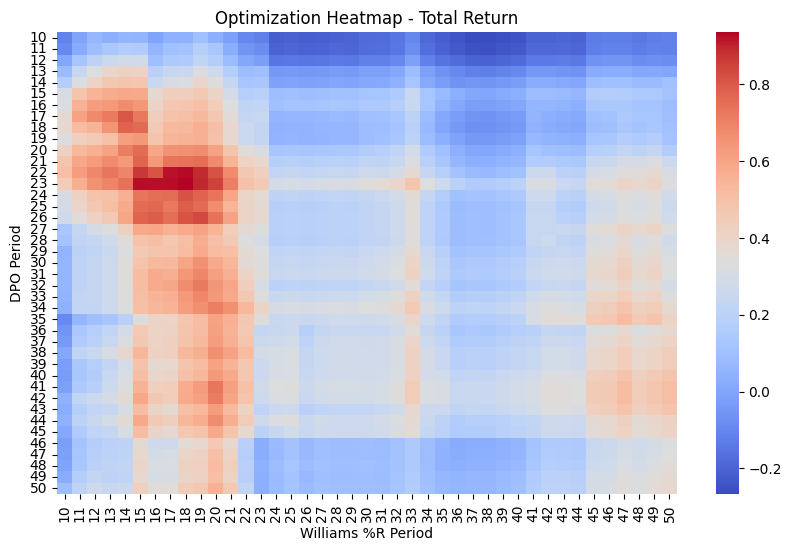

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Detrended Price Oscillator (DPO)
def calculate_dpo(df, period):
    return df['Close'] - df['Close'].rolling(window=period).mean()

# Function to calculate Williams %R
def calculate_williams_r(df, period):
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()
    return -100 * ((high_rolling - df['Close']) / (high_rolling - low_rolling))

# Define stock and date range
symbol = 'SI=F'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
dpo_periods = np.arange(10, 51)  # DPO periods from 10 to 50
williams_periods = np.arange(10, 51)  # Williams %R periods from 10 to 50

# Create parameter grid
dpo_grid, williams_grid = np.meshgrid(dpo_periods, williams_periods, indexing='ij')

# Initialize results storage
returns_matrix = np.zeros_like(dpo_grid, dtype=float)

# Perform backtests for each parameter combination
for i in range(dpo_grid.shape[0]):
    for j in range(dpo_grid.shape[1]):
        dpo_period = dpo_grid[i, j]
        williams_period = williams_grid[i, j]

        # Calculate indicators
        df['DPO'] = calculate_dpo(df, period=dpo_period)
        df['Williams_R'] = calculate_williams_r(df, period=williams_period)

        # Filter data for the test period (2020-2025)
        df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

        # Define entry and exit signals
        entries = (df_filter['DPO'] < 0) & (df_filter['Williams_R'] < -80)
        exits = (df_filter['Williams_R'] > -20) | (df_filter['DPO'] > 0)

        # Run backtest
        portfolio = vbt.Portfolio.from_signals(
            close=df_filter['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        # Store total return
        returns_matrix[i, j] = portfolio.total_return()

# Find the best parameters
best_idx = np.unravel_index(np.argmax(returns_matrix), returns_matrix.shape)
best_dpo = dpo_grid[best_idx]
best_williams = williams_grid[best_idx]

print(f"🔥 Best DPO period: {best_dpo}")
print(f"🔥 Best Williams %R period: {best_williams}")

# Plot heatmap of total returns
plt.figure(figsize=(10, 6))
sns.heatmap(returns_matrix, xticklabels=williams_periods, yticklabels=dpo_periods, annot=False, cmap="coolwarm", fmt=".2f")
plt.xlabel("Williams %R Period")
plt.ylabel("DPO Period")
plt.title("Optimization Heatmap - Total Return")
plt.show()


In [15]:
# Calculate Detrended Price Oscillator (DPO)
df['DPO'] = calculate_dpo(df, period=23)

# Calculate Williams %R
df['Williams_R'] = calculate_williams_r(df, period=18)

# Define Entry and Exit signals based on DPO and Williams %R
df['Entry'] = (df['DPO'] < 0) & (df['Williams_R'] < -80)
df['Exit'] = (df['Williams_R'] > -20) | (df['DPO'] > 0)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           193485.506199
Total Return [%]                        93.485506
Benchmark Return [%]                     61.08205
Max Gross Exposure [%]                      100.0
Total Fees Paid                      11223.372345
Max Drawdown [%]                        33.609266
Max Drawdown Duration                       306.0
Total Trades                                   44
Total Closed Trades                            43
Total Open Trades                               1
Open Trade PnL                       -1224.115573
Win Rate [%]                            74.418605
Best Trade [%]                            9.22023
Worst Trade [%]                        -14.609637
Avg Winning Trade [%]                    3.595562
Avg Losing Trade [%]                    -3.967345
